In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## 1. Problem Setup and Data Generation

We generate a random instance of the problem with $n=25$ variables and $m=10$ constraints.
$Q$ is constructed to be positive definite.

In [2]:
def get_Q_A_b(m, n):
    """
    Generate random problem data.
    Q : (n, n) positive definite matrix
    A : (m, n) matrix
    b : (m,) vector
    """
    # Generate random matrix and make it positive definite
    Q = np.random.rand(n, n) - 0.5
    Q = 10 * Q @ Q.T + 0.1 * np.eye(n)
    
    A = np.random.normal(size=(m, n))
    b = 2 * (np.random.rand(m) - 0.5)
    return Q, A, b

m, n = 10, 25
Q, A, b = get_Q_A_b(m, n)
print(f"Generated Q shape: {Q.shape}, A shape: {A.shape}, b shape: {b.shape}")

Generated Q shape: (25, 25), A shape: (10, 25), b shape: (10,)


## 2. Exact Solution via KKT System

Since this is a quadratic problem with linear equality constraints, we can find the exact solution $x^*$ by solving the KKT system:

$$
\begin{bmatrix} 2Q & A^T \\ A & 0 \end{bmatrix} \begin{bmatrix} x^* \\ \lambda^* \end{bmatrix} = \begin{bmatrix} 0 \\ b \end{bmatrix}
$$

We will use this exact solution to evaluate the convergence of our iterative method.

In [3]:
def get_soln(Q, A, b):
    """
    Get exact solution of equality constrained quadratic program using KKT matrix.
    """
    # Construct KKT matrix
    # [ 2Q   A^T ]
    # [ A     0  ]
    kkt_matrix = np.block([
        [2 * Q, A.T],
        [A, np.zeros((A.shape[0], A.shape[0]))]
    ])
    
    # Construct RHS vector [0, b]
    rhs = np.zeros(Q.shape[0] + A.shape[0])
    rhs[Q.shape[0]:] = b
    
    # Solve linear system
    sol = np.linalg.solve(kkt_matrix, rhs)
    
    # Return only the x part of the solution
    return sol[:Q.shape[0]]

x_star = get_soln(Q, A, b)
print(f"Exact solution x_star norm: {np.linalg.norm(x_star):.4f}")
print(f"Constraint violation ||Ax* - b||: {np.linalg.norm(A @ x_star - b):.2e}")

Exact solution x_star norm: 0.7758
Constraint violation ||Ax* - b||: 5.39e-15


## 3. Augmented Lagrangian and Gradients

We define helper functions to compute the objective $f(x)$, the constraint residual $h(x) = Ax - b$, the Augmented Lagrangian $L_c(x, \lambda)$, and its gradient $\nabla_x L_c(x, \lambda)$.

The gradient is given by:
$$
\nabla_x L_c(x, \lambda) = 2Qx + A^T (\lambda + c(Ax - b))
$$

In [4]:
def get_h_x(A, b, x):
    """Constraint residual h(x) = Ax - b"""
    h = A @ x - b
    return h

def get_f(Q, x):
    """Objective function f(x) = x^T Q x"""
    f = x.T @ Q @ x
    return f

def get_Lc(Q, A, b, c, lamb, x):
    """
    Augmented Lagrangian L_c(x, lambda)
    """
    f_x = get_f(Q, x)
    h_x = get_h_x(A, b, x)
    Lc = f_x + lamb.T @ h_x + (c / 2) * (h_x.T @ h_x)
    return Lc

def get_grad_Lc_respect_to_x(Q, A, b, c, lamb, x):
    """
    Gradient of L_c with respect to x.
    grad_x L_c = 2Qx + A^T(lambda + c(Ax - b))
    """
    return 2 * Q @ x + A.T @ (c * (A @ x - b) + lamb)

## 4. Inner Loop: Minimization with Gradient Descent

In the inner loop, we minimize $L_c(x, \lambda_k)$ with respect to $x$ while keeping $\lambda_k$ and $c_k$ fixed. We use **Gradient Descent** with **Armijo's Rule** for step size selection to ensure convergence.

**Armijo's Rule:**
Find step size $\alpha$ such that:
$$
L_c(x + \alpha d) \le L_c(x) + \sigma \alpha \nabla L_c(x)^T d
$$
where $d = -\nabla L_c(x)$ is the descent direction.

In [5]:
def find_alpha_with_armijo(Q, A, b, c, x_k, lamb_k, grad_Lc_of_x_k, beta=0.5, sigma=1e-4):
    """
    Find the step size alpha using Armijo's rule.
    """
    curr_val = get_Lc(Q, A, b, c, lamb_k, x_k)
    alpha = 1.0
    d_k = -grad_Lc_of_x_k
    
    # Directional derivative: grad^T * d = - ||grad||^2
    update_dir = -grad_Lc_of_x_k.T @ grad_Lc_of_x_k  

    # Backtracking line search
    while get_Lc(Q, A, b, c, lamb_k, x_k + alpha * d_k) > curr_val + sigma * alpha * update_dir:
        alpha *= beta
        
    return alpha

def inner_loop_with_fixed_lamb_k_and_c_k(Q, A, b, c_k, lamb_k, epsilon, x0=None, beta=0.5, max_iter=1000):
    """
    Minimize L_c_k(x, lambda_k) using Gradient Descent with Armijo's rule.
    Stops when ||grad_x L_c|| < epsilon.
    """
    if x0 is None:
        x0 = np.zeros(Q.shape[0])
    
    k = 0 # iteration counter
    x_cur = x0.copy()
    grad_cur = get_grad_Lc_respect_to_x(Q, A, b, c_k, lamb_k, x_cur)
    
    while np.linalg.norm(grad_cur, ord=2) >= epsilon and k < max_iter:
        step_size = find_alpha_with_armijo(Q, A, b, c_k, x_cur, lamb_k, grad_cur, beta=beta)
        x_cur -= step_size * grad_cur
        grad_cur = get_grad_Lc_respect_to_x(Q, A, b, c_k, lamb_k, x_cur)
        k += 1
        
    return x_cur, k

## 5. Outer Loop: Method of Multipliers

The outer loop updates the dual variables $\lambda$ and the penalty parameter $c$.

**Update Rules:**
1.  **x update**: $x_{k+1} = \arg\min_x L_{c_k}(x, \lambda_k)$ (solved by inner loop)
2.  **lambda update**: $\lambda_{k+1} = \lambda_k + c_k (A x_{k+1} - b)$
3.  **c update**: We explore 4 different strategies for updating $c_k$.

**Strategies for $c_k$:**
1.  **Constant**: $c_{k+1} = c_k$ (Fixed value)
2.  **Linear Increase**: $c_{k+1} = c_k + \beta$
3.  **Geometric Increase**: $c_{k+1} = c_k \times \beta$
4.  **Adaptive**: Increase $c$ only if the constraint violation does not decrease sufficiently.
    If $\|h(x_{k+1})\| > \gamma \|h(x_k)\|$, then $c_{k+1} = c_k \times \beta$, else $c_{k+1} = c_k$.

In [6]:
def get_next_c(current_c, select_method_idx, beta=1.1, constant_c=10, A=None, b=None, gamma=None, x_curr=None, x_prev=None):
    """
    Update rule for penalty parameter c based on the selected strategy.
    """
    if select_method_idx == 1:
        # Constant c
        return constant_c
    elif select_method_idx == 2:
        # Linear increase
        return current_c + beta
    elif select_method_idx == 3:
        # Geometric increase
        return current_c * beta
    elif select_method_idx == 4:
        # Adaptive update
        h_curr = np.linalg.norm(get_h_x(A, b, x_curr))
        h_prev = np.linalg.norm(get_h_x(A, b, x_prev))
        
        if h_curr > gamma * h_prev:
            return current_c * beta
        else:
            return current_c
    else:
        raise ValueError("Invalid select_method_idx")

def outer_loop(Q, A, b, x_star, c_select_method_idx, epsilon=1e-4, 
               beta=1.1, gamma=0.9, constant_c=10, max_outer_iter=100):
    """
    Main loop for Method of Multipliers.
    """
    x = np.zeros(Q.shape[0])
    lamb = np.zeros(A.shape[0])
    c = 1.0 # Initial c

    # Track relative error ||x - x*|| / ||x*||
    outer_error_list = []
    outer_error_list.append(np.linalg.norm(x - x_star, ord=2) / np.linalg.norm(x_star, ord=2))

    outer_iter = 0
    inner_iter_list = []

    # Stop when constraint violation is small enough
    while np.linalg.norm(get_h_x(A, b, x), ord=2) >= epsilon and outer_iter < max_outer_iter:
        x_prev = x.copy()
        
        # Inner loop: minimize L_c w.r.t x
        x, inner_loop_iter = inner_loop_with_fixed_lamb_k_and_c_k(
            Q, A, b, c, lamb, epsilon, x0=x)

        # Update lambda: lambda <- lambda + c * h(x)
        h_k = get_h_x(A, b, x)
        lamb += c * h_k
        
        # Update c based on strategy
        c = get_next_c(c, c_select_method_idx, 
                       beta=beta, A=A, b=b, gamma=gamma, x_curr=x, x_prev=x_prev)

        # Record error
        outer_error_list.append(np.linalg.norm(x - x_star, ord=2) / np.linalg.norm(x_star, ord=2))
        outer_iter += 1
        inner_iter_list.append(inner_loop_iter)
        
    return x, outer_error_list, outer_iter, inner_iter_list

## 6. Experimental Results

We run the Method of Multipliers with the following 4 strategies:
1.  **Constant c=5**
2.  **Linear c+=2** (Add 2 at each step)
3.  **Geometric c*=1.5** (Multiply by 1.5 at each step)
4.  **Adaptive c*=2.0** (Multiply by 2.0 if constraint violation doesn't improve by factor 0.25)

In [7]:
strategies = [
    {"idx": 1, "name": "Constant c=5", "beta": 0, "gamma": 0},
    {"idx": 2, "name": "Linear c+=2", "beta": 2.0, "gamma": 0},
    {"idx": 3, "name": "Geometric c*=1.5", "beta": 1.5, "gamma": 0},
    {"idx": 4, "name": "Adaptive c*=2.0", "beta": 2.0, "gamma": 0.25} 
]

results = {}
epsilon = 1e-4

print(f"{'Strategy':<20} | {'Outer Iters':<12} | {'Final Error':<12} | {'Total Inner Steps':<18}")
print("-" * 70)

for strat in strategies:
    x_final, errors, outer_k, total_inner_k = outer_loop(
        Q, A, b, x_star, 
        c_select_method_idx=strat['idx'], 
        epsilon=epsilon,
        beta=strat['beta'],
        gamma=strat['gamma'],
        constant_c=5
    )
    
    results[strat['name']] = errors
    
    # Sum of inner iterations
    total_inner_steps = sum(total_inner_k)
    
    print(f"{strat['name']:<20} | {outer_k:<12} | {errors[-1]:.2e}    | {total_inner_steps:<18}")

Strategy             | Outer Iters  | Final Error  | Total Inner Steps 
----------------------------------------------------------------------
Constant c=5         | 8            | 4.23e-05    | 2380              
Linear c+=2          | 8            | 8.60e-05    | 1921              
Geometric c*=1.5     | 9            | 6.33e-05    | 2404              
Adaptive c*=2.0      | 8            | 5.00e-05    | 1703              


## 7. Convergence Plot

We plot the relative error $\frac{\|x^{(k)} - x^*\|_2}{\|x^*\|_2}$ versus the outer iteration count $k$.

<>:19: SyntaxWarning: invalid escape sequence '\{'
<>:19: SyntaxWarning: invalid escape sequence '\{'
/var/folders/pg/dplfd1vx0sq7ggmc6x1jxctm0000gn/T/ipykernel_41612/3276361381.py:19: SyntaxWarning: invalid escape sequence '\{'
  plt.title('Convergence of Method of Multipliers with Different $\{c_k\}$')


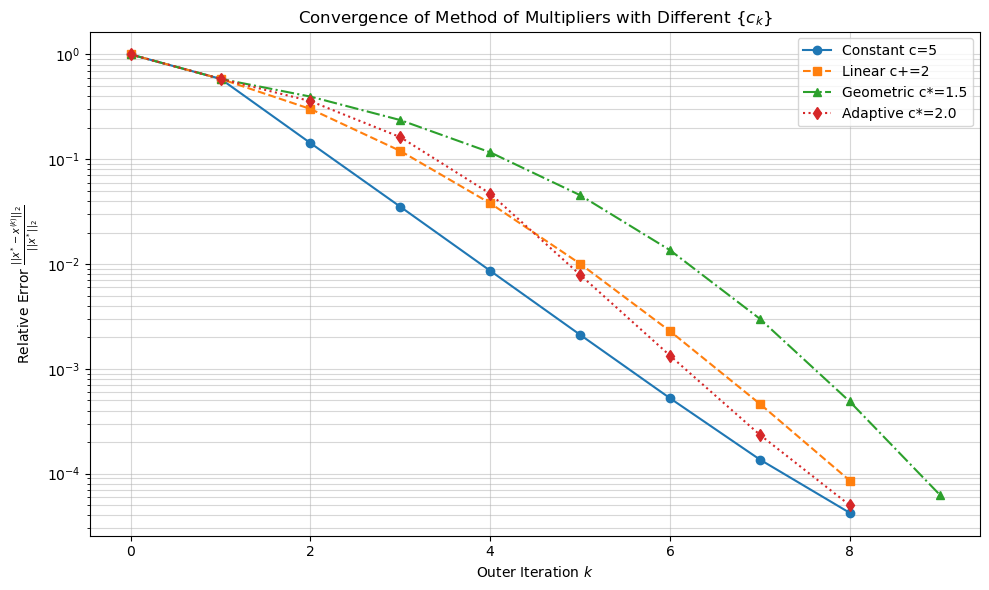

In [8]:
def plot_results(results_dict):
    """
    Plot convergence of different strategies.
    """
    plt.figure(figsize=(10, 6))
    
    markers = ['o', 's', '^', 'd']
    line_styles = ['-', '--', '-.', ':']
    
    for i, (name, errors) in enumerate(results_dict.items()):
        plt.semilogy(errors, 
                     label=name, 
                     marker=markers[i % len(markers)], 
                     linestyle=line_styles[i % len(line_styles)],
                     markevery=max(1, len(errors)//10))
    
    plt.xlabel('Outer Iteration $k$')
    plt.ylabel('Relative Error $\\frac{||x^* - x^{(k)}||_2}{||x^*||_2}$')
    plt.title('Convergence of Method of Multipliers with Different $\{c_k\}$')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_results(results)